# Decision Tree for Telco Churn Analysis

Utilizing data retrieved from a Kaggle dataset to build a logistic regression model aimed at predicting customer churn rates.  

Also included is an analysis to identify the most significant features and their correlation to churn rates, along with possible business suggestions  

In [459]:
import os
import warnings
import pandas as pd
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from matplotlib import pyplot as plt
from sklearn import tree
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
from sklearn.datasets import make_classification

In [467]:
destination =  os.environ.get('LR_Destination')
ChurnData = pd.read_csv(str(destination + '/' + 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))

Although Decision Trees can train on complex non-linear relationships to determine the relationship between a feature and a  target variable, it can't understand categorical features that are expressed through strings like `'Yes'` or `'No'` / `'Female'` or `'Male'` so we must map to these to numerical values without necessarily needing to create indicator variables unlike with building a logistic regression model.

Data Transformation

In [461]:
#First drop off customerID column
if 'customerID' in ChurnData.columns.values:
     ChurnData = ChurnData.drop(['customerID'],axis=1)
else:
     1==1

#Converting Total Charges to Float
ChurnData['TotalCharges'] = pd.to_numeric(ChurnData['TotalCharges'], errors='coerce').fillna(pd.to_numeric(ChurnData['TotalCharges'], errors='coerce').mean())


unique_values_dict = {}
for cols in ChurnData.columns.values:
    if ChurnData[cols].dtypes != 'int64' and ChurnData[cols].dtypes != 'float64':
          unique_values_dict[cols] = ChurnData[cols].unique()

In [462]:
for i in unique_values_dict:
    remapped_values = {}
    names_and_remapped_values = {}

    #for i in range of length of values in key:values for gender
    for iterator in range(len(unique_values_dict[i])):
        remapped_values[unique_values_dict[i][iterator]] = iterator

        names_and_remapped_values[i] = remapped_values 

    for key in names_and_remapped_values:
        ChurnData[key] = ChurnData[key].map(names_and_remapped_values[key])

Hyperparameter Performance Comparison [GridSearchCV provides the most optimal hyperparameters]

In [ ]:
Churn_X = ChurnData.iloc[:, 0:19].to_numpy()
Churn_y = ChurnData['Churn'].to_numpy()

CD_X_train, CD_X_test, CD_y_train, CD_y_test = train_test_split(
    Churn_X, Churn_y, test_size=0.2, random_state=42
)

array = [i for i in range(1,11)]
 
param_dist = {
    "max_depth": array,
    "max_features": array,
    "min_samples_leaf": array,
    "criterion": ["gini", "entropy"]
}

model = tree.DecisionTreeClassifier()

rs = RandomizedSearchCV(model, param_dist, cv=5)
rs = rs.fit(CD_X_train, CD_y_train)
rs_pred = rs.predict(CD_X_test)

gs = GridSearchCV(model, param_dist, cv=5)
gs = gs.fit(CD_X_train, CD_y_train)
gs_pred = gs.predict(CD_X_test)

model = model.fit(CD_X_train, CD_y_train)
model_pred = model.predict(CD_X_test)

print(f"RandomizedSearchCV Performance: " + str(round(accuracy_score(CD_y_test, rs_pred) * 100, 2)) + "%")
print("RandomizedSearchCV chosen hyperparameters: " + str(rs.best_params_) + "\n")
print("Classification Report [RandomizedSearchCV]: \n \n" + classification_report(CD_y_test, rs_pred))

print(f"GridSearchCV Performance: " + str(round(accuracy_score(CD_y_test, gs_pred) * 100, 2)) + "%")
print("GridScoreCV chosen hyperparameters: " + str(gs.best_params_) + "\n")
print("Classification Report [GridSearchCV]: \n \n" + classification_report(CD_y_test, rs_pred))

print(f'Default Hyperparameter Performance: ' + str(round(accuracy_score(CD_y_test, model_pred) * 100, 2)) + "%")
print("Default Model chosen hyperparameters: " + str(model.get_params()) + "\n")
print("Classification Report [Default]: \n \n" + classification_report(CD_y_test, model_pred))


RandomizedSearchCV Performance: 78.78%
RandomizedSearchCV chosen hyperparameters: {'min_samples_leaf': 5, 'max_features': 4, 'max_depth': 7, 'criterion': 'gini'}

Classification Report [RandomizedSearchCV]: 
 
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1036
           1       0.62      0.52      0.56       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

GridSearchCV Performance: 79.35%
GridScoreCV chosen hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 6}

Classification Report [GridSearchCV]: 
 
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1036
           1       0.62      0.52      0.56       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      14

### Decision Tree Building

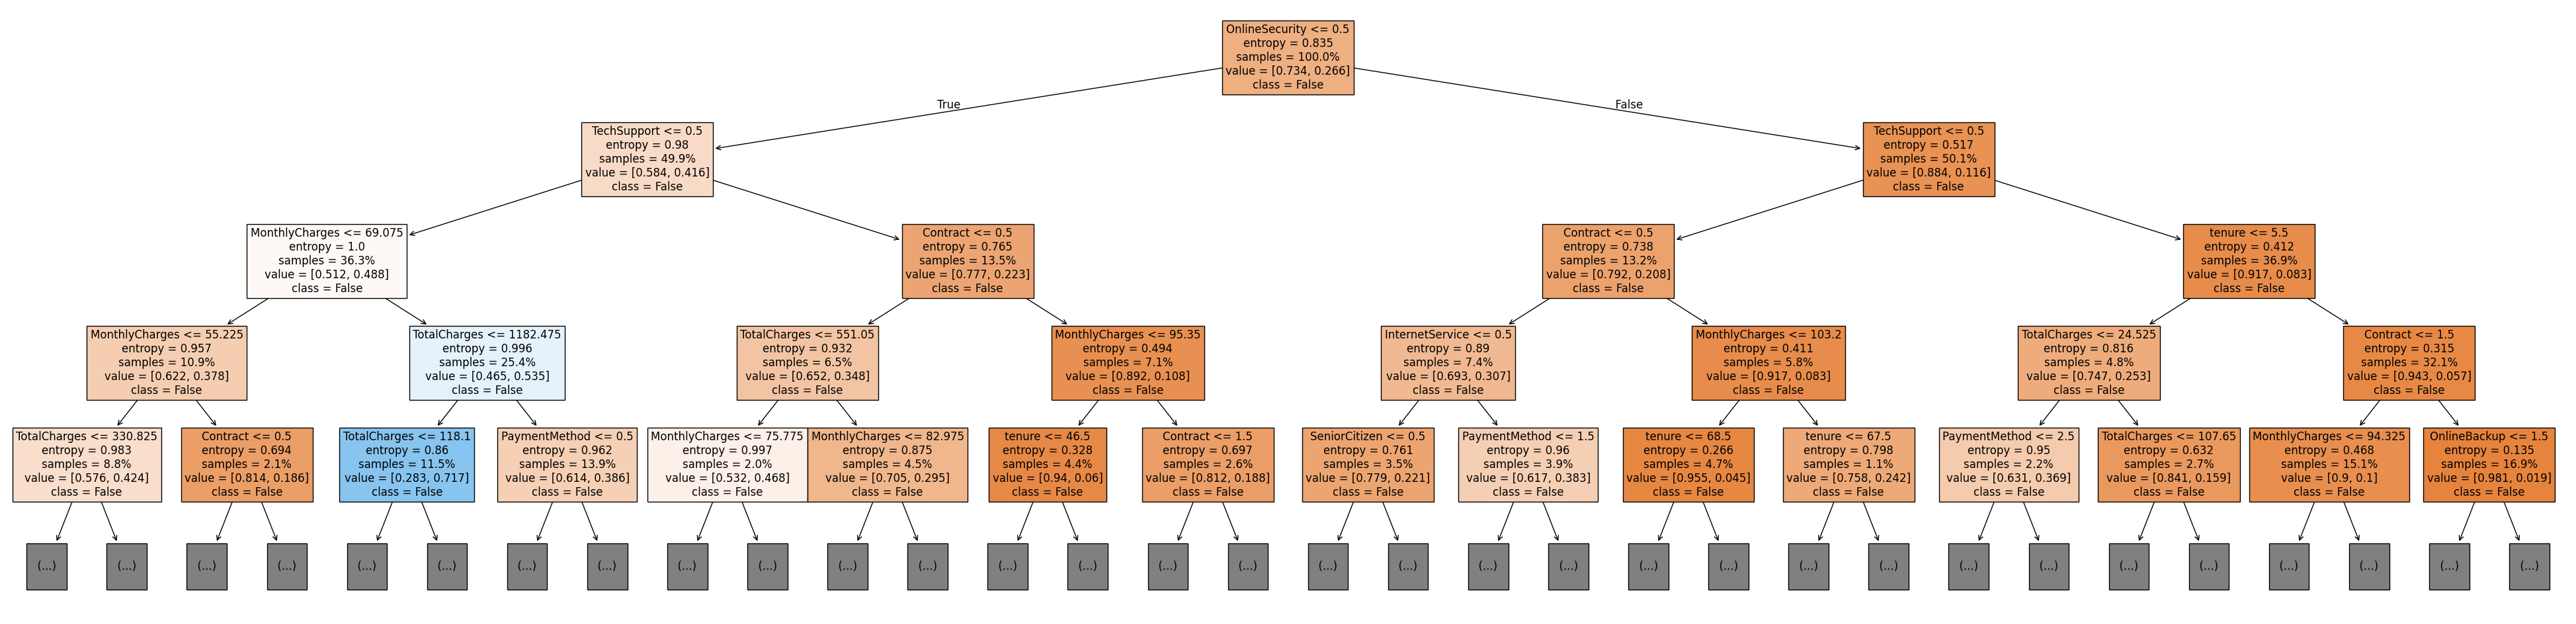

In [465]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(50,12))

figures = tree.plot_tree(gs.best_estimator_
                ,max_depth=4
                ,proportion=True
                ,fontsize=12
                ,feature_names=[header for header in ChurnData.columns]
                ,filled=True
                ,class_names=np.array([str(header == 'Churn') for header in ChurnData.columns])
                )

<u>**Decision Tree Analysis**</u>

Root Node: **`PaymentMethod`** being in the root node suggests that highest impact on Churn Probability was this field. There were several methods of payment including Electronic check, Mailed Check, Bank transfer (automatic), and credit card (automatic). It would be worth exploring how one method of payment may be causing more churn against others.

Leaf Nodes: **`OnlineBackup`** and **`Tenure`** had the lowest entropy scores, at the leaves. This would indicate that Tenure and Onlinebackup had a very strong relationship to Churn levels.

\
<u>**Hyperparameter Improvement**</u>

Hyperparameter tuning increased all overall metrics with tuning. GridSearchCV showed improvements in the following metrics

- **Precision** *(Churn)*: **0.49 -> 0.68**  
- **Recall** *(Non-Churn)*: **0.81 -> 0.93**  
- **F1-Score**:  
  - *(Churn)*: **0.50 -> 0.52**  
  - *(Non-Churn)*: **0.82 -> 0.87**

\
<u>**Business Interpretation / Next Steps**</u>

- Research different payment methods in the company and see which ones are more prone to Churn.
- Tenure also had a large effect on whether a customer had churned. Incentivize customers with either lower tenure or higher tenure. Tenure also accounted for a little over 9% of the entire dataset, and the metrics indicate that 94-95% of customers churn or stay dependent on tenure amount, example, perhaps a temporary free subscription for users that haven't stayed with the company long.
-  OnlineBackup services also had a large effect on customer churn, it would be worth analyzing this feature more. perhaps implementing discounts for online backup services 
